# Link Prediction Using Binary Classification

https://machinelearningmastery.com/calculate-feature-importance-with-python/

## 1. Imports

In [1]:
import pandas as pd
import networkx as nx
import sklearn
import math
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

## 2. Feature Generation

In [2]:
def loadTrainDataAsUndirectedGraph():
    filename = "train.txt"
    rows = [line.rstrip("\n") for line in open(filename)]
    g = nx.Graph()
    for row in rows:
        authorIds = row.split()
        for i, author in enumerate(authorIds):
            for coauthor in authorIds[i+1:]:
                if g.has_edge(author, coauthor):
                    g[author][coauthor]['frequency'] += 1
                else:
                    g.add_edge(author, coauthor, frequency=1)
    return g

In [3]:
def loadTrainDataAsUndirectedMultiGraph():
    filename = "train.txt"
    rows = [line.rstrip("\n") for line in open(filename)]
    g = nx.MultiGraph()
    for row in rows:
        authorIds = row.split()
        for i, author in enumerate(authorIds):
            for coauthor in authorIds[i+1:]:
                g.add_edge(author, coauthor)
    return g

In [4]:
def createBalancedData(graph):
    allAuthors = list(graph.nodes)
    trueInstances = []
    falseInstances = []
    print('Authors to iterate:',len(allAuthors) )
    
    # Get true instances and false instances
    for i, author1 in enumerate(allAuthors):
        if(i%100==0): print('.', end='') # Status indicator
        for author2 in allAuthors[i+1:]:
            if graph.has_edge(author1, author2):
                freq = graph[author1][author2]['frequency']
                if freq > 1:
                    # True instances
                    trueInstances.append({
                        "Source": author1,
                        "Sink": author2,
                        "Freq": graph[author1][author2]['frequency'],
                        "Coauthor": 1 })
            else:
                # False instances (instances that are more than 3 hops away)
                author1Neighbors = list(nx.all_neighbors(graph, author1))
                author2Neighbors = list(nx.all_neighbors(graph, author2))
                if (len(author1Neighbors)==1 and len(author2Neighbors)==1):
                    common = len(list(nx.common_neighbors(graph, author1Neighbors[0], author2Neighbors[0])))
                    if common == 0:
                        falseInstances.append({
                            "Source": author1,
                            "Sink": author2,
                            "Freq": 0,
                            "Coauthor": 0 })
    print('')
    
    # Downsample false instances
    numTrue = len(trueInstances)
    falseInstances = sklearn.utils.resample(
                        falseInstances,
                        n_samples=numTrue,
                        random_state=0)  # TODO: Hardcoded random state
    
    print('Generated',numTrue,'instances where coauthor=True')
    print('Generated',len(falseInstances),'instances where coauthor=False')
    
    # Shuffle training data
    data = sklearn.utils.shuffle(trueInstances+falseInstances, random_state=0) # TODO: Hardcoded random state
    return pd.DataFrame(data=data)

In [5]:
def createBalancedDataForMultiGraph(graph):
    allAuthors = list(graph.nodes)
    trueInstances = []
    falseInstances = []
    print('Authors to iterate:',len(allAuthors) )
    
    # Get true instances and false instances
    for i, author1 in enumerate(allAuthors):
        if(i%100==0): print('.', end='') # Status indicator
        for author2 in allAuthors[i+1:]:
            if graph.has_edge(author1, author2):
                # True instances
                trueInstances.append({
                    "Source": author1,
                    "Sink": author2,
                    "Coauthor": 1 })
            else:
                # False instances (instances that are more than 3 hops away)
                author1Neighbors = list(nx.all_neighbors(graph, author1))
                author2Neighbors = list(nx.all_neighbors(graph, author2))
                if (len(author1Neighbors)==1 and len(author2Neighbors)==1):
                    common = len(list(nx.common_neighbors(graph, author1Neighbors[0], author2Neighbors[0])))
                    if common == 0:
                        falseInstances.append({
                            "Source": author1,
                            "Sink": author2,
                            "Coauthor": 0 })
    print('')
    
    # Downsample false instances
    numTrue = len(trueInstances)
    falseInstances = sklearn.utils.resample(
                        falseInstances,
                        n_samples=numTrue,
                        random_state=0)  # TODO: Hardcoded random state
    
    print('Generated',numTrue,'instances where coauthor=True')
    print('Generated',len(falseInstances),'instances where coauthor=False')
    
    # Shuffle training data
    data = sklearn.utils.shuffle(trueInstances+falseInstances, random_state=0) # TODO: Hardcoded random state
    return pd.DataFrame(data=data)

In [6]:
def shortestDistance(graph, n1, n2):
    try: return len(nx.dijkstra_path(graph, source=n1, target=n2)) - 1
    except: return 100
    
def commonNeighbours(graph, n1, n2):
    try: return len(list(nx.common_neighbors(graph, n1, n2)))
    except: return 0

def jaccard(graph, n1, n2):
    try: return list(nx.jaccard_coefficient(graph, [(n1, n2)]))[0][2]
    except: return 0
    
def adamicAdar(graph, n1, n2):
    try: return list(nx.adamic_adar_index(graph, [(n1, n2)]))[0][2]
    except: return 0

def preferentialAttachment(graph, n1, n2):
    try: return list(nx.preferential_attachment(graph, [(n1, n2)]))[0][2]
    except: return 0

def resourceAllocation(graph, n1, n2):
    try: return list(nx.resource_allocation_index(graph, [(n1, n2)]))[0][2]
    except: return 0

In [7]:
gUndirected = loadTrainDataAsUndirectedGraph()
dtUndirected = createBalancedData(gUndirected)
dtUndirected['Dist'] = dtUndirected.apply(lambda l: shortestDistance(gUndirected,l.Source,l.Sink),axis=1)
print('Added "Dist" column')
dtUndirected['CommonNeighbours'] = dtUndirected.apply(lambda l: commonNeighbours(gUndirected,l.Source,l.Sink),axis=1)
print('Added "CommonNeighbours" column')
dtUndirected['Jaccard'] = dtUndirected.apply(lambda l: jaccard(gUndirected,l.Source,l.Sink),axis=1)
print('Added "Jaccard" column')
dtUndirected['AdamicAdar'] = dtUndirected.apply(lambda l: adamicAdar(gUndirected,l.Source,l.Sink),axis=1)
print('Added "AdamicAdar" column')
dtUndirected['PreferentialAttachment'] = dtUndirected.apply(lambda l: preferentialAttachment(gUndirected,l.Source,l.Sink),axis=1)
print('Added "PreferentialAttachment" column')
dtUndirected['ResourceAllocation'] = dtUndirected.apply(lambda l: resourceAllocation(gUndirected,l.Source,l.Sink),axis=1)
print('Added "ResourceAllocation" column')
dtUndirected.describe()

Authors to iterate: 3767
......................................
Generated 4813 instances where coauthor=True
Generated 4813 instances where coauthor=False
Added "Dist" column
Added "CommonNeighbours" column
Added "Jaccard" column
Added "AdamicAdar" column
Added "PreferentialAttachment" column
Added "ResourceAllocation" column


,Freq,Coauthor,Dist,CommonNeighbours,Jaccard,AdamicAdar,PreferentialAttachment,ResourceAllocation
count,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000,9626.000000
mean,1.911178,0.500000,30.464887,3.381882,0.098923,1.200650,392.509869,0.221741
std,2.949533,0.500026,44.186350,7.608390,0.162869,2.145670,1184.579811,0.333580
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,0.500000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,1.000000,100.000000,4.000000,0.136364,1.759569,232.000000,0.399986
max,45.000000,1.000000,100.000000,76.000000,0.882353,18.264381,12792.000000,3.391595


In [8]:
gUndirectedMulti = loadTrainDataAsUndirectedMultiGraph()
dtUndirectedMulti = createBalancedDataForMultiGraph(gUndirectedMulti)
dtUndirectedMulti['Dist'] = dtUndirectedMulti.apply(lambda l: shortestDistance(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "Dist" column')
dtUndirectedMulti['CommonNeighbours'] = dtUndirectedMulti.apply(lambda l: commonNeighbours(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "CommonNeighbours" column')
dtUndirectedMulti['Jaccard'] = dtUndirectedMulti.apply(lambda l: jaccard(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "Jaccard" column')
dtUndirectedMulti['AdamicAdar'] = dtUndirectedMulti.apply(lambda l: adamicAdar(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "AdamicAdar" column')
dtUndirectedMulti['PreferentialAttachment'] = dtUndirectedMulti.apply(lambda l: preferentialAttachment(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "PreferentialAttachment" column')
dtUndirectedMulti['ResourceAllocation'] = dtUndirectedMulti.apply(lambda l: resourceAllocation(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "ResourceAllocation" column')
dtUndirectedMulti.describe()

Authors to iterate: 3767
......................................
Generated 16034 instances where coauthor=True
Generated 16034 instances where coauthor=False
Added "Dist" column
Added "CommonNeighbours" column
Added "Jaccard" column
Added "AdamicAdar" column
Added "PreferentialAttachment" column
Added "ResourceAllocation" column


,Coauthor,Dist,CommonNeighbours,Jaccard,AdamicAdar,PreferentialAttachment,ResourceAllocation
count,32068.000000,32068.000000,32068.000000,32068.0,32068.0,32068.0,32068.0
mean,0.500000,30.570413,4.826587,0.0,0.0,0.0,0.0
std,0.500008,44.243624,9.990679,0.0,0.0,0.0,0.0
min,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.500000,2.000000,0.000000,0.0,0.0,0.0,0.0
75%,1.000000,100.000000,4.000000,0.0,0.0,0.0,0.0
max,1.000000,100.000000,76.000000,0.0,0.0,0.0,0.0


In [9]:
testUndirected = pd.read_csv('test-public.csv', converters = {'Source': str, 'Sink': str})
testUndirected['Dist'] = testUndirected.apply(lambda l: shortestDistance(gUndirected,l.Source,l.Sink),axis=1)
print('Added "Dist" column')
testUndirected['CommonNeighbours'] = testUndirected.apply(lambda l: commonNeighbours(gUndirected,l.Source,l.Sink),axis=1)
print('Added "CommonNeighbours" column')
testUndirected['Jaccard'] = testUndirected.apply(lambda l: jaccard(gUndirected,l.Source,l.Sink),axis=1)
print('Added "Jaccard" column')
testUndirected['AdamicAdar'] = testUndirected.apply(lambda l: adamicAdar(gUndirected,l.Source,l.Sink),axis=1)
print('Added "AdamicAdar" column')
testUndirected['PreferentialAttachment'] = testUndirected.apply(lambda l: preferentialAttachment(gUndirected,l.Source,l.Sink),axis=1)
print('Added "PreferentialAttachment" column')
testUndirected['ResourceAllocation'] = testUndirected.apply(lambda l: resourceAllocation(gUndirected,l.Source,l.Sink),axis=1)
print('Added "ResourceAllocation" column')
testUndirected.describe()

Added "Dist" column
Added "CommonNeighbours" column
Added "Jaccard" column
Added "AdamicAdar" column
Added "PreferentialAttachment" column
Added "ResourceAllocation" column


,Id,Dist,CommonNeighbours,Jaccard,AdamicAdar,PreferentialAttachment,ResourceAllocation
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,13.599500,1.342000,0.064341,0.530868,231.747500,0.112561
std,577.494589,30.418477,3.344941,0.141352,1.157031,637.358269,0.239929
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,500.750000,2.000000,0.000000,0.000000,0.000000,14.000000,0.000000
50%,1000.500000,3.000000,0.000000,0.000000,0.000000,48.000000,0.000000
75%,1500.250000,5.000000,1.000000,0.054054,0.507102,183.250000,0.066140
max,2000.000000,100.000000,41.000000,1.000000,10.915808,9163.000000,1.996653


In [10]:
testUndirectedMulti = pd.read_csv('test-public.csv', converters = {'Source': str, 'Sink': str})
testUndirectedMulti['Dist'] = testUndirectedMulti.apply(lambda l: shortestDistance(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "Dist" column')
testUndirectedMulti['CommonNeighbours'] = testUndirectedMulti.apply(lambda l: commonNeighbours(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "CommonNeighbours" column')
testUndirectedMulti['Jaccard'] = testUndirectedMulti.apply(lambda l: jaccard(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "Jaccard" column')
testUndirectedMulti['AdamicAdar'] = testUndirectedMulti.apply(lambda l: adamicAdar(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "AdamicAdar" column')
testUndirectedMulti['PreferentialAttachment'] = testUndirectedMulti.apply(lambda l: preferentialAttachment(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "PreferentialAttachment" column')
testUndirectedMulti['ResourceAllocation'] = testUndirectedMulti.apply(lambda l: resourceAllocation(gUndirectedMulti,l.Source,l.Sink),axis=1)
print('Added "ResourceAllocation" column')
testUndirectedMulti.describe()

Added "Dist" column
Added "CommonNeighbours" column
Added "Jaccard" column
Added "AdamicAdar" column
Added "PreferentialAttachment" column
Added "ResourceAllocation" column


,Id,Dist,CommonNeighbours,Jaccard,AdamicAdar,PreferentialAttachment,ResourceAllocation
count,2000.000000,2000.000000,2000.000000,2000.0,2000.0,2000.0,2000.0
mean,1000.500000,13.599500,1.342000,0.0,0.0,0.0,0.0
std,577.494589,30.418477,3.344941,0.0,0.0,0.0,0.0
min,1.000000,1.000000,0.000000,0.0,0.0,0.0,0.0
25%,500.750000,2.000000,0.000000,0.0,0.0,0.0,0.0
50%,1000.500000,3.000000,0.000000,0.0,0.0,0.0,0.0
75%,1500.250000,5.000000,1.000000,0.0,0.0,0.0,0.0
max,2000.000000,100.000000,41.000000,0.0,0.0,0.0,0.0


## 3. Training & Testing Data

In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
trainXUndirected = dtUndirected[['Dist', 'CommonNeighbours','Jaccard', 'AdamicAdar', 'PreferentialAttachment','ResourceAllocation']]
trainYUndirected = dtUndirected['Coauthor']

In [13]:
trainXUndirectedMulti = dtUndirectedMulti[['Dist', 'CommonNeighbours','Jaccard', 'AdamicAdar', 'PreferentialAttachment','ResourceAllocation']]
trainYUndirectedMulti = dtUndirectedMulti['Coauthor']

In [14]:
testXUndirected = testUndirected[['Dist', 'CommonNeighbours',
       'Jaccard', 'AdamicAdar', 'PreferentialAttachment',
       'ResourceAllocation']]

In [15]:
testXUndirectedMulti = testUndirectedMulti[['Dist', 'CommonNeighbours',
       'Jaccard', 'AdamicAdar', 'PreferentialAttachment',
       'ResourceAllocation']]

In [16]:
testIds = testUndirected['Id']

## 4. Visualisation

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

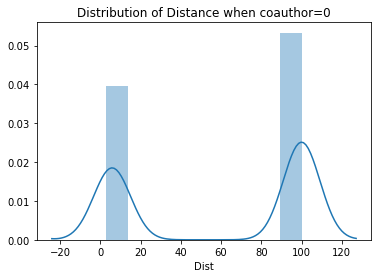

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


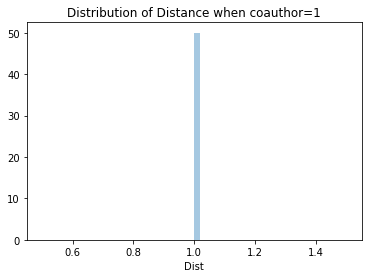

In [18]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['Dist']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of Distance when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['Dist']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of Distance when coauthor=1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


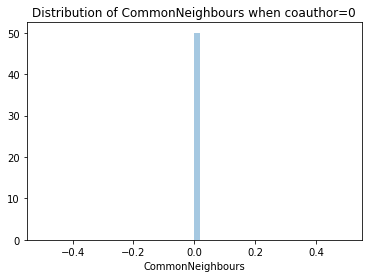

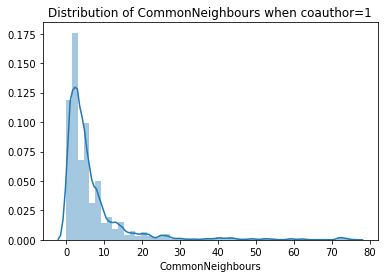

In [19]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['CommonNeighbours']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of CommonNeighbours when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['CommonNeighbours']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of CommonNeighbours when coauthor=1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


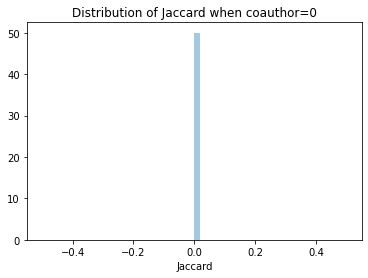

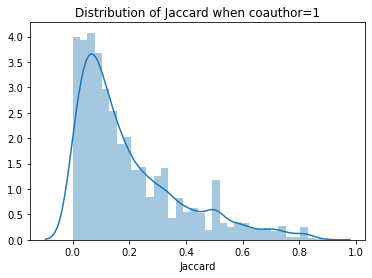

In [20]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['Jaccard']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of Jaccard when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['Jaccard']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of Jaccard when coauthor=1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


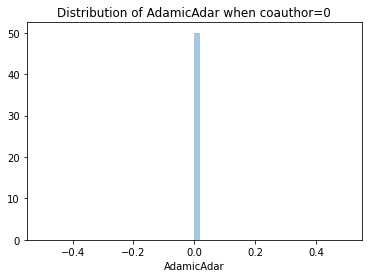

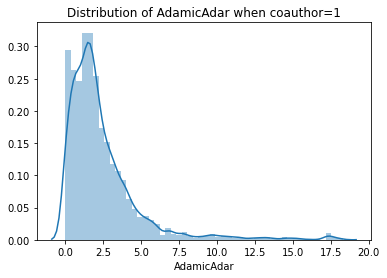

In [21]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['AdamicAdar']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of AdamicAdar when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['AdamicAdar']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of AdamicAdar when coauthor=1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


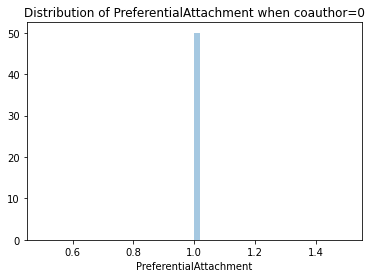

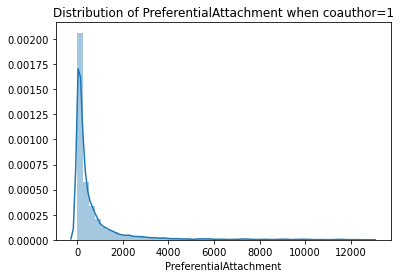

In [22]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['PreferentialAttachment']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of PreferentialAttachment when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['PreferentialAttachment']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of PreferentialAttachment when coauthor=1')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


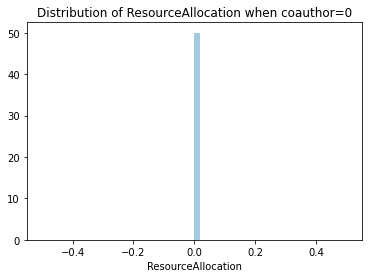

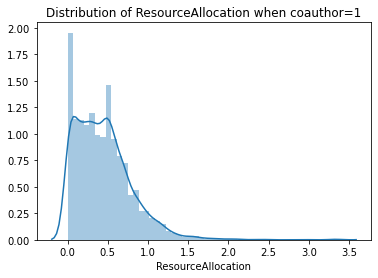

In [23]:
gd = dtUndirected[dtUndirected['Coauthor']==0]['ResourceAllocation']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of ResourceAllocation when coauthor=0')
plt.show()

gd = dtUndirected[dtUndirected['Coauthor']==1]['ResourceAllocation']
g = sns.distributions.distplot(gd)
g.set_title('Distribution of ResourceAllocation when coauthor=1')
plt.show()

## 5. Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

In [25]:
linearRegressionUndirected = LinearRegression()
print('Undirected Scores: ',
    cross_val_score(linearRegressionUndirected, trainXUndirected, trainYUndirected, cv=5))

Undirected Scores:  [0.63413772 0.64163563 0.65436054 0.63722995 0.64275272]


In [26]:
linearRegressionUndirectedMulti = LinearRegression()
print('Undirected Multi Scores: ',
    cross_val_score(linearRegressionUndirectedMulti, trainXUndirectedMulti, trainYUndirectedMulti, cv=5))

Undirected Multi Scores:  [0.52001669 0.52673623 0.53498154 0.52469447 0.52543998]


## 6. Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
logisticRegressionUndirected = LogisticRegression(random_state=0)
print('Undirected Scores: ',
    cross_val_score(logisticRegressionUndirected, trainXUndirected, trainYUndirected, cv=5))

Undirected Scores:  [1. 1. 1. 1. 1.]


In [29]:
logisticRegressionUndirectedMulti = LogisticRegression(random_state=0)
print('Undirected Multi Scores: ',
    cross_val_score(logisticRegressionUndirectedMulti, trainXUndirectedMulti, trainYUndirectedMulti, cv=5))

Undirected Multi Scores:  [1. 1. 1. 1. 1.]


In [30]:
#########################################
# Kaggle Score = 0.80095
#########################################
logisticRegressionUndirected.fit(trainXUndirected, trainYUndirected)
logisticResultUndirected = pd.DataFrame({
    'Id': testIds,
    'Predicted': [prob[1] for prob in logisticRegressionUndirected.predict_proba(testXUndirected)]
})
logisticResultUndirected.to_csv('results/LogisticRegressionUndirected.csv', index=False)
logisticResultUndirected.head()

,Id,Predicted
0,1,1.000000
1,2,0.999968
2,3,1.000000
3,4,1.000000
4,5,1.000000


,features,importance
0,Dist,-2.773991
1,CommonNeighbours,0.100864
2,Jaccard,0.032356
3,AdamicAdar,0.106247
4,PreferentialAttachment,0.776024
5,ResourceAllocation,0.035696


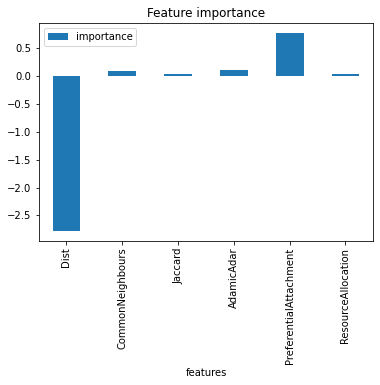

In [31]:
# summarize feature importance
logisticFeaturesUndirected = pd.DataFrame({
    'features': trainXUndirected.columns,
    'importance': logisticRegressionUndirected.coef_[0]
})
ax = logisticFeaturesUndirected.plot.bar(x='features', rot=90)
ax.set_title('Feature importance')
logisticFeaturesUndirected

In [32]:
#########################################
# Kaggle Score = 0.80096
#########################################
logisticRegressionUndirectedMulti.fit(trainXUndirectedMulti, trainYUndirectedMulti)
logisticResultUndirectedMulti = pd.DataFrame({
    'Id': testIds,
    'Predicted': [prob[1] for prob in logisticRegressionUndirectedMulti.predict_proba(testXUndirectedMulti)]
})
logisticResultUndirectedMulti.to_csv('results/LogisticRegressionUndirectedMulti.csv', index=False)
logisticResultUndirectedMulti.head()

,Id,Predicted
0,1,0.226630
1,2,0.000078
2,3,0.226630
3,4,0.999914
4,5,0.004745


,features,importance
0,Dist,-2.773991
1,CommonNeighbours,0.100864
2,Jaccard,0.032356
3,AdamicAdar,0.106247
4,PreferentialAttachment,0.776024
5,ResourceAllocation,0.035696


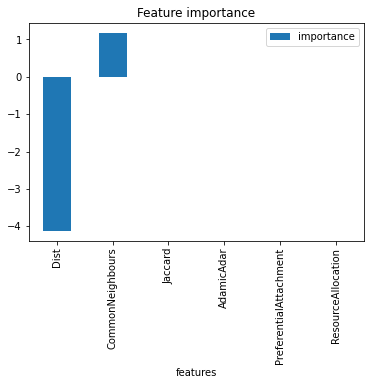

In [33]:
# summarize feature importance
logisticFeaturesUndirectedMulti = pd.DataFrame({
    'features': trainXUndirectedMulti.columns,
    'importance': logisticRegressionUndirectedMulti.coef_[0]
})
ax = logisticFeaturesUndirectedMulti.plot.bar(x='features', rot=90)
ax.set_title('Feature importance')
logisticFeaturesUndirected

## 7. Neural Network

In [34]:
from sklearn.neural_network import MLPClassifier

In [35]:
neuralNetworkUndirected = MLPClassifier(random_state=1, max_iter=300)
print('Undirected Scores: ',
    cross_val_score(neuralNetworkUndirected, trainXUndirected, trainYUndirected, cv=5))

Undirected Scores:  [1. 1. 1. 1. 1.]


In [36]:
neuralNetworkUndirectedMulti = MLPClassifier(random_state=1, max_iter=300)
print('Undirected Multi Scores: ',
    cross_val_score(neuralNetworkUndirectedMulti, trainXUndirectedMulti, trainYUndirectedMulti, cv=5))

Undirected Multi Scores:  [1. 1. 1. 1. 1.]


In [37]:
#########################################
# Kaggle Score = 0.79482
#########################################
neuralNetworkUndirected.fit(trainXUndirected, trainYUndirected)
neuralNetworkResultUndirected = pd.DataFrame({
    'Id': testIds,
    'Predicted': [prob[1] for prob in neuralNetworkUndirected.predict_proba(testXUndirected)]
})
# neuralNetworkResultUndirected.to_csv('results/neuralNetworkUndirected.csv', index=False)
neuralNetworkResultUndirected.head()

,Id,Predicted
0,1,1.0
1,2,1.0
2,3,1.0
3,4,1.0
4,5,1.0


In [38]:
print({
    'n_layers': neuralNetworkUndirected.n_layers_,
    'n_iter': neuralNetworkUndirected.n_iter_
})

{'n_layers': 3, 'n_iter': 32}


In [39]:
#########################################
# Kaggle Score = should be similar to neuralNetworkUndirected as it seems like mutigraph does not add much value
#########################################
neuralNetworkUndirectedMulti.fit(trainXUndirectedMulti, trainYUndirectedMulti)
neuralNetworkResultUndirectedMulti = pd.DataFrame({
    'Id': testIds,
    'Predicted': [prob[1] for prob in neuralNetworkUndirectedMulti.predict_proba(testXUndirectedMulti)]
})
neuralNetworkResultUndirectedMulti.to_csv('results/neuralNetworkUndirectedMulti.csv', index=False)
neuralNetworkResultUndirectedMulti.head()

,Id,Predicted
0,1,0.187632
1,2,0.000322
2,3,0.187632
3,4,1.000000
4,5,0.005307


In [40]:
print({
    'n_layers': neuralNetworkUndirectedMulti.n_layers_,
    'n_iter': neuralNetworkUndirectedMulti.n_iter_
})

{'n_layers': 3, 'n_iter': 26}
